In [1]:
import numpy as np
import scipy 
from sympy import *
import pylab as plt
import math
from scipy.integrate import odeint
from scipy import integrate
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.special import spherical_jn, spherical_yn
%matplotlib inline

In [2]:
#Universal Constants
h = 6.6260715e-34 #m^2 kg / s
hbar = h/(2*np.pi)
c = 2.99792458e8 #m/s
kb = 1.380649e-23 #Joules per Kelvin

In [3]:
def Silvera_Triplet(R):
    conv = 5.06e-4
    x = R / conv / 4.16 
    D = 1.28
    K2eV = 8.61732814974056e-5
    F=(x>D)+(x<D)*np.exp(-(D/x-1)**2)
    return 6.46 * K2eV * (4.889e4*np.exp(0.0968-8.6403*x-2.427*x**2)-(1.365/x**6+0.425/x**8+0.183/x**10)*F)

def Triplet(x): 
    conv = 1973.27
    R = x * conv
    P = np.exp(0.09678-1.10173*R-0.03945*R**2)+np.exp(-(10.04/R-1)**2)*(-6.5/R**6-124/R**8-3285/R**10)
    return P*27

def J(Rho):
    R = Rho * 1973.27 
    P = np.exp(-.288-.275*R-.176*R**2+.0068*R**3)
    return P*27

def Singlet(R):
    return Silvera_Triplet(R) - J(R)

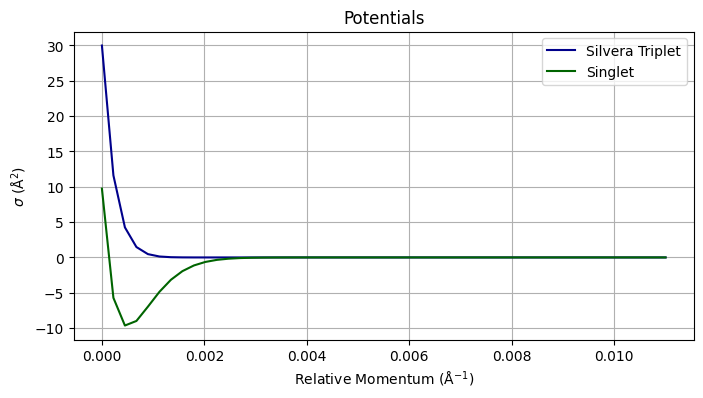

In [4]:
a = .011
rhos = np.linspace(1e-9, a, 50)
plt.figure(figsize=(8, 4))
plt.plot(rhos,Silvera_Triplet(rhos), label="Silvera Triplet", color='DarkBlue')
plt.plot(rhos,Singlet(rhos), label="Singlet", color='DarkGreen')
plt.xlabel(r"Relative Momentum (Å$^{-1}$)") 
plt.ylabel(r"$\sigma$ (Å$^2$)")  
plt.title("Potentials")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
def p_of_temp(mu, T):
    J2eV = 6.242e18
    return np.sqrt(2 * mu * kb * J2eV * T)
 
def pprime(pin, epsa, epsb, epsprimea, epsprimeb, mu):
    E = pin**2 / (2 * mu)
    Eprime = E + epsa + epsb - epsprimea - epsprimeb
    pprime = np.sqrt(2 * mu * Eprime)
    return pprime

def p_abs(mu, pin, epsa, epsb, epsprimea, epsprimeb):
    psquared = pin**2 + mu * (epsa + epsb - epsprimea - epsprimeb)
    return np.sqrt(psquared)

In [6]:
def ddx(y, rho, mu, Potential, l, pin):
    u = y[0]
    v = y[1]
    dudr = v
    dvdr = (-pin**2 + 2 * mu * Potential(rho) + l * (l + 1) / (rho**2)) * u
    return [dudr,dvdr]

def Wave_Function(pin, l, bigrho, r0, function, mass, version, int_type):
    rhos = np.linspace(r0, bigrho, 1000)
    init = [r0,1]
    def ddxToint(rhos, y):
        return function(y, rhos, mass, version, l, pin)
    State = scipy.integrate.solve_ivp(ddxToint, (rhos[0], rhos[-1]), init, t_eval=rhos, method = int_type)
    Normalization = np.sqrt(State.y[0]**2 + (State.y[1]/pin)**2)
    return np.sqrt(2/np.pi) * State.y[0]/Normalization[-1]

def GetPhaseShift(bigrho, p, l, r0, mass, version, how_to_int):
    rhos = np.linspace(r0, bigrho, 1000)
    init = [r0,1]
    
    State = np.array(Wave_Function(p, l, bigrho, r0, ddx, mass, version, how_to_int)[0])
    Statedev = np.array(Wave_Function(p, l, bigrho, r0, ddx, mass, version, how_to_int)[1])

    deltas = np.arctan(p * State / Statedev) - p * rhos
    return deltas[-1]

def GetSpatials(mu, B, levels, version_one, version_two):
    aaSpatials = []
    acSpatials = []
    bdSpatials = []
    i = 0
    for bs in B:
        a = levels['a'][i]
        b = levels['b'][i]
        c = levels['c'][i]
        d = levels['d'][i]

        r0 = 1e-9
        temp = 5e-4
        intlimit = .01

        Pin = p_of_temp(mu, temp)
        Paa = pprime(Pin, c, c, a, a, mu)
        Pac = pprime(Pin, c, c, c, a, mu)
        Pbd = pprime(Pin, c, c, b, d, mu)
        Pabsaa = p_abs(mu, Pin, c, c, a, a)
        Pabsac = p_abs(mu, Pin, c, c, a, c)
        Pabsbd = p_abs(mu, Pin, c, c, b, d)

        const = np.pi / (mu * Pin)
        
        tdeltaaa = GetPhaseShift(intlimit, Pabsaa, 0, r0, mu, version_one, 'Radau')
        tdeltaac = GetPhaseShift(intlimit, Pabsac, 0, r0, mu, version_one, 'Radau')
        tdeltabd = GetPhaseShift(intlimit, Pabsbd, 0, r0, mu, version_one, 'Radau')

        sdeltaaa = GetPhaseShift(intlimit, Pabsaa, 0, r0, mu, version_two, 'Radau')
        sdeltaac = GetPhaseShift(intlimit, Pabsaa, 0, r0, mu, version_two, 'Radau')
        sdeltabd = GetPhaseShift(intlimit, Pabsaa, 0, r0, mu, version_two, 'Radau')

        aaSpatials.append(const * (Pin * Paa / Pabsaa**2) * (np.sin(tdeltaaa - sdeltaaa)**2))
        acSpatials.append(const * (Pin * Pac / Pabsac**2) * (np.sin(tdeltaac - sdeltaac)**2))
        bdSpatials.append(const * (Pin * Pbd / Pabsbd**2) * (np.sin(tdeltabd - sdeltabd)**2))

        i = i + 1

    aaSpatials = np.array(aaSpatials)
    acSpatials = np.array(acSpatials)
    bdSpatials = np.array(bdSpatials)

    return(aaSpatials, acSpatials, bdSpatials)

In [7]:
def Phases(mu, B, levels, pont_one, pont_two):
    taaPhase = []
    tacPhase = []
    tbdPhase = []
    saaPhase = []
    sacPhase = []
    sbdPhase = []
    i = 0
    for bs in B:
        a = levels['a'][i]
        b = levels['b'][i]
        c = levels['c'][i]
        d = levels['d'][i]

        r0 = 1e-9
        temp = 5e-4
        intlimit = .02

        Pin = p_of_temp(mu, temp)
        Paa = pprime(Pin, c, c, a, a, mu)
        Pac = pprime(Pin, c, c, a, c, mu)
        Pbd = pprime(Pin, c, c, b, d, mu)
        
        Pabsaa = p_abs(mu, Pin, c, c, a, a)
        Pabsac = p_abs(mu, Pin, c, c, a, c)
        Pabsbd = p_abs(mu, Pin, c, c, b, d)

        tdeltaaa = GetPhaseShift(intlimit, Pabsaa, 0, r0, mu, pont_one, 'Radau')
        tdeltaac = GetPhaseShift(intlimit, Pabsac, 0, r0, mu, pont_one, 'Radau')
        tdeltabd = GetPhaseShift(intlimit, Pabsbd, 0, r0, mu, pont_one, 'Radau')

        sdeltaaa = GetPhaseShift(intlimit, Pabsaa, 0, r0, mu, pont_two, 'Radau')
        sdeltaac = GetPhaseShift(intlimit, Pabsac, 0, r0, mu, pont_two, 'Radau')
        sdeltabd = GetPhaseShift(intlimit, Pabsbd, 0, r0, mu, pont_two, 'Radau')

        taaPhase.append(tdeltaaa)
        tacPhase.append(tdeltaac)
        tbdPhase.append(tdeltabd)
        saaPhase.append(sdeltaaa)
        sacPhase.append(sdeltaac)
        sbdPhase.append(sdeltabd)
        
        i = i + 1

    taaPhase = np.array(taaPhase)
    tacPhase = np.array(tacPhase)
    tbdPhase = np.array(tbdPhase)
    saaPhase = np.array(saaPhase)
    sacPhase = np.array(sacPhase)
    sbdPhase = np.array(sbdPhase)

    return(taaPhase, tacPhase, tbdPhase, saaPhase, sacPhase, sbdPhase)

In [8]:
B_Values = np.logspace(-3,1,30)

In [9]:
def GetHyperFineLevels(pm, mf, delW, mN, gI):
    gL = 1 #Orbital g-factor
    gS = 2 #Electron spin g-factor
    L = 0 #Orbital Angular Momentum
    S = .5 #Electron spin
    I = .5 #Nuclear spin
    J = .5 #Total Angular Momentum
    ge = 2.002319 #Electron g-factor
    meeV = .511e6 #mass of electron
    mue = 9.27e-24 #magnetic moment of electron
    muN = mue*meeV/(mN*1e9) #magnetic moment of nucleus
    J2eV = 6.242e18
    
    gJ = gL * (J * (J + 1) + L * (L + 1) - S * (S + 1)) / (2 * J * (J + 1)) + ge * (J * (J + 1) - L * (L +1) + S * (S + 1)) / (2 * J *(J + 1))

    x = B_Values * (gJ * mue - gI * muN) / (h * delW)
    Term1 = -h * delW / (2 * (2 * I + 1)) * np.ones_like(B_Values)
    Term2 = muN * gI * mf * B_Values

    if(abs(mf)==abs(I + .5)):
        sgn = mf / (I + .5)
        Term3 = h*delW / 2 * (1 + sgn*x)
    else:
        Term3 = pm * h * delW / 2 * np.sqrt(1 + 2 * mf * x / (I + .5) + x**2)

    delE = (Term1 + Term2 + Term3) / h

    return delE * h * J2eV

def AllHFLevels(delW, mN, gI): 
    delEs = []
    for pm in [-1,1]:
        F = .5 + pm/2
        for mF in np.arange(-F, F+1, 1):
            delEs.append(GetHyperFineLevels(pm, mF, delW, mN, gI))
    delEs = np.array(delEs)
    delEs = np.sort(delEs, axis = 0)
    delEDict={}
    for i in range(0,4):
        letter = chr(97 + i)
        delEDict[letter]=delEs[i]
    return delEDict

In [10]:
delWH = 1.4204057517667e9 #Hyperfine of hydrogen splitting constant in Hz
delWT = 1.516701396e9
gIH = 5.585694702 # Hydrogen nuclear g-factor
gIT = 5.95792492 
mH = 1.00784 #Mass of hydrogen in Dalton
mT = 3.01604928 

HLevels = AllHFLevels(delWH, mH, gIH)
TLevels = AllHFLevels(delWT, mT, gIT)

In [11]:
e=symbols('e')
c=symbols('c')
s=symbols('s')
sr2=symbols('sr2')
sr3=symbols('sr3')

In [12]:
def LetterToNumber(letter):
    if(letter=="a"):
        return 0
    elif(letter=="b"):
        return 1
    elif(letter=="c"):
        return 2
    elif(letter=="d"):
        return 3
    else:
        print("invalid letter state, "+str(letter))
        assert(0)

In [13]:
def NumberToLetter(num):
    if(num==0):
        return "a"
    elif(num==1):
        return "b"
    elif(num==2):
        return "c"
    elif(num==3):
        return "d"
    else:
        print("invalid number state, "+str(num))
        assert(0)

In [14]:
def StateToBasis(in1,in2,p=1):
    # convert letter basis to number basis
    if(type(in1)==str):
        in1=LetterToNumber(in1)
    else:
        in1=int(in1)
    if(type(in2)==str):
        in2=LetterToNumber(in2)
    else:
        in2=int(in2)
    #swap so first one is always smaller
    if(in2<in1):
        in1old=in1
        in1=in2
        in2=in1old

    if(in1==0 and in2==0 and p==1):
        return 0
    if(in1==1 and in2==1 and p==1):
        return 1
    if(in1==2 and in2==2 and p==1):
        return 2
    if(in1==3 and in2==3 and p==1):
        return 3
    if(in1==0 and in2==1 and p==1):
        return 4
    if(in1==0 and in2==1 and p==-1):
        return 5
    if(in1==0 and in2==2 and p==1):
        return 6
    if(in1==0 and in2==2 and p==-1):
        return 7
    if(in1==0 and in2==3 and p==1):
        return 8
    if(in1==0 and in2==3 and p==-1):
        return 9
    if(in1==1 and in2==2 and p==1):
        return 10
    if(in1==1 and in2==2 and p==-1):
        return 11
    if(in1==1 and in2==3 and p==1):
        return 12
    if(in1==1 and in2==3 and p==-1):
        return 13
    if(in1==2 and in2==3 and p==1):
        return 14
    if(in1==2 and in2==3 and p==-1):
        return 15

In [15]:
SingletProj=np.array([
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1/2,0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1/2,0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, -1/2,0,  0,  0,  0,  0, 1/2, 0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, -1/2,0,  0,  0,  0,  0, 1/2, 0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
                ])

TripletProj=np.array([
    [1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0, 0.5,0.5, 0,  0],
    [0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, 0.5, 0,  0,  0,  0,  0, 0.5, 0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, 0.5, 0,  0,  0,  0,  0, 0.5, 0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1]
                ])

In [16]:
Rotator=[
    [1,  0,  0,  0,  0,  0, 2*e, 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  1,  0,  0,  0, -2*e,0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  e,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0, -e,  0,  0,  0,  0],
    [-e, 0,  e,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0, -e,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  e,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  -e, 0,  0,  0,  0,  1,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  -e, 0,  0,  0,  0,  1]
                ]


Rotator=np.array([
    [c*c,0,  s*s,0,  0,  0,sr2*s*c,0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [s*s,0,  c*c,0,  0,  0,-sr2*s*c,0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  c,  0,  0,  0,  0,  0,  s,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  c,  0,  0,  0,  0,  0, -s,  0,  0,  0,  0],
    [-sr2*s*c,0,sr2*s*c, 0,  0,  0,  c*c-s*s,0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  c*c-s*s,0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  c,  0,  0,  0,  0,  0,  s,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  c,  0,  0,  0,  0,  0,  s],
    [0,  0,  0,  0, -s,  0,  0,  0,  0,  0,  c,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  s,  0,  0,  0,  0,  0,  c,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  -s, 0,  0,  0,  0,  c,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  -s, 0,  0,  0,  0,  c]
                ])

In [17]:
def TransformMatrix(M,R):
    return(np.matmul(np.transpose(R),np.matmul(M,R)))

def RotateByEpsilon(M,eps):
    M1=TransformMatrix(M,Rotator)
    return(EvaluateWithEpsilon(M,eps))

def EvaluateWithEpsilon(M,eps):
    return np.array([(i+0*e).subs(e,eps) for i in M.flatten()]).reshape(M.shape).astype(float)

In [18]:
def GetElement(M,alpha, beta, p1, alphaprime, betaprime, pprime):
    index1=StateToBasis(alpha,beta,p1)
    index2=StateToBasis(alphaprime,betaprime,pprime)
    return(M[index1,index2])

In [19]:
def Theta(a, B, gamN):
    game = -28024.9*1e6
    return (0.5*np.arctan(a / (2 * B * (game + gamN))))

def GetSpin(delW, B, gam, a3, a4):
    NormDiff = 1
    line = []
    a1 = 'c'
    a2 = 'c'
    
    for b in B:
        theta = Theta(2 * delW, b, gam)
        value = 0
        El = (GetElement(TransformMatrix((TripletProj - SingletProj), Rotator), a1, a2, 1, a3, a4, 1))**2
        try: 
            value += El.subs(sr2, np.sqrt(2)) \
                                .subs(sr3, np.sqrt(3)) \
                                .subs(c, np.cos(theta)) \
                                .subs(s, np.sin(theta))
        except:
            value += 0
        line.append(value)
    line = np.array(line)*NormDiff**2
    return line

In [20]:
Hm = 938.78e6 #Mass of hydrogen in eV/c^2
Tm = 2808.9261e6
Hmu = Hm/2
Tmu = Tm/2

delWH = 1.4204057517667e9 #Hyperfine of hydrogen splitting constant in Hz
delWT = 1.516701396e9
#gyromagnetic constants 
gamH=42.577*1e6 # In Hz T^-1
gamT=45.415*1e6 # In Hz T^-1

HSpatials = GetSpatials(Hmu, B_Values, HLevels, Silvera_Triplet, Singlet)
TSpatials = GetSpatials(Tmu, B_Values, TLevels, Silvera_Triplet, Singlet)

HSpinaa = GetSpin(delWH, B_Values, gamH, 'a', 'a')
HSpinac = GetSpin(delWH, B_Values, gamH, 'a', 'c')
HSpinbd = GetSpin(delWH, B_Values, gamH, 'b', 'd')
TSpinaa = GetSpin(delWT, B_Values, gamT, 'a', 'a')
TSpinac = GetSpin(delWT, B_Values, gamT, 'a', 'c')
TSpinbd = GetSpin(delWT, B_Values, gamT, 'b', 'd')

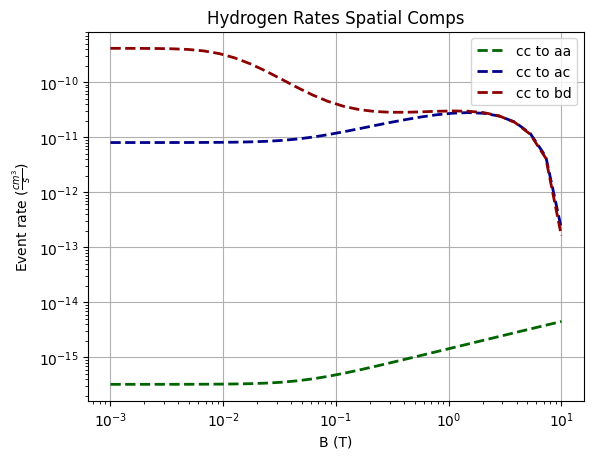

In [21]:
plt.plot(B_Values,HSpatials[0],  '--', label="cc to aa", color = "DarkGreen", linewidth=2)
plt.plot(B_Values,HSpatials[1],  '--', label="cc to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Values,HSpatials[2],  '--', label="cc to bd", color = "DarkRed", linewidth=2)
plt.xlabel("B (T)")
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.title("Hydrogen Rates Spatial Comps")
plt.grid(True)
plt.legend()
plt.loglog()
plt.show()

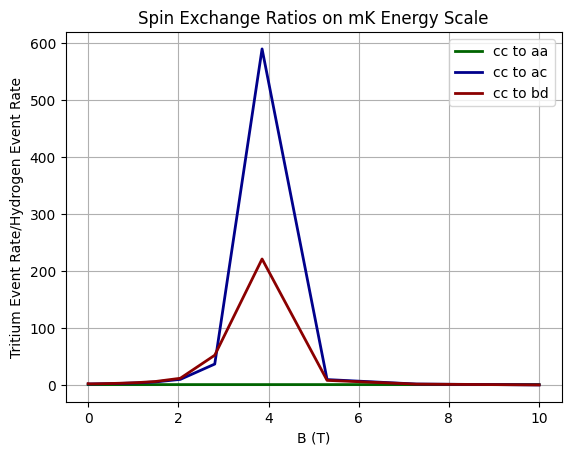

In [22]:
plt.plot(B_Values,HSpatials[0]/TSpatials[0], label="cc to aa", color = "DarkGreen", linewidth=2)
plt.plot(B_Values,HSpatials[1]/TSpatials[1], label="cc to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Values,HSpatials[2]/TSpatials[2], label="cc to bd", color = "DarkRed", linewidth=2)
plt.xlabel("B (T)")

plt.ylabel("Tritium Event Rate/Hydrogen Event Rate")
plt.title("Spin Exchange Ratios on mK Energy Scale")
plt.grid(True)
plt.legend()
plt.show()

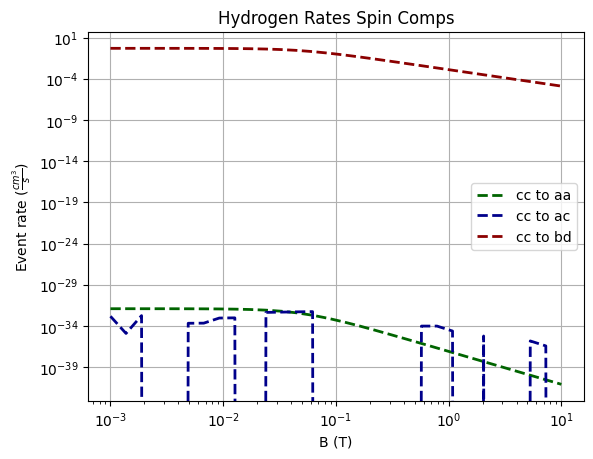

In [23]:
plt.plot(B_Values,HSpinaa,  '--', label="cc to aa", color = "DarkGreen", linewidth=2)
plt.plot(B_Values,HSpinac,  '--', label="cc to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Values,HSpinbd,  '--', label="cc to bd", color = "DarkRed", linewidth=2)
plt.xlabel("B (T)")
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.title("Hydrogen Rates Spin Comps")
plt.grid(True)
plt.legend()
plt.loglog()
plt.show()

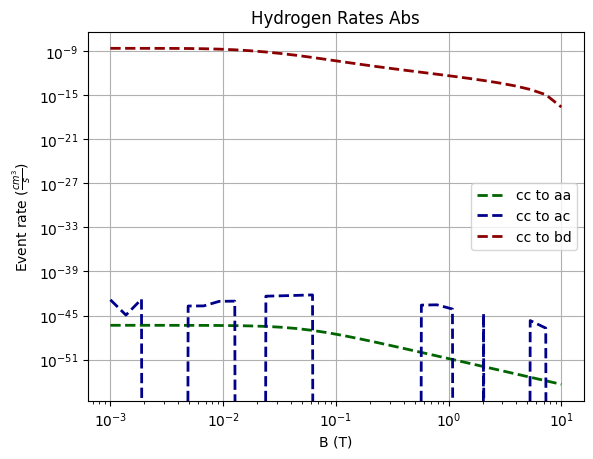

In [24]:
Conversion = 11.6

plt.plot(B_Values, Conversion * HSpatials[0] * HSpinaa,  '--', label="cc to aa", color = "DarkGreen", linewidth=2)
plt.plot(B_Values, Conversion * HSpatials[1] * HSpinac,  '--', label="cc to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Values, Conversion * HSpatials[2] * HSpinbd,  '--', label="cc to bd", color = "DarkRed", linewidth=2)
plt.xlabel("B (T)")
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.title("Hydrogen Rates Abs")
plt.grid(True)
plt.legend()
plt.loglog()
plt.show()

In [ ]:
HPhases = Phases(Hmu, B_Values, HLevels, Silvera_Triplet, Singlet)
TPhases = Phases(Tmu, B_Values, TLevels, Silvera_Triplet, Singlet)

In [ ]:
plt.plot(B_Values,HPhases[0],  '--', label="Triplet cc to aa", color = "DarkGreen", linewidth=2)
plt.plot(B_Values,HPhases[1],  '--', label="Triplet cc to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Values,HPhases[2],  '--', label="Triplet cc to bd", color = "DarkRed", linewidth=2)
plt.plot(B_Values,HPhases[3], label="Singlet cc to aa", color = "DarkGreen", linewidth=1)
plt.plot(B_Values,HPhases[4], label="Singlet cc to ac", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,HPhases[5], label="Singlet cc to bd", color = "DarkRed", linewidth=1)
plt.xlabel("B (T)")
plt.ylabel("Phase Shifts")
plt.title("Hydrogen Phase Shifts")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
plt.plot(B_Values,TPhases[0],  '--', label="Triplet cc to aa", color = "DarkGreen", linewidth=2)
plt.plot(B_Values,TPhases[1],  '--', label="Triplet cc to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Values,TPhases[2],  '--', label="Triplet cc to bd", color = "DarkRed", linewidth=2)
plt.plot(B_Values,TPhases[3], label="Singlet cc to aa", color = "DarkGreen", linewidth=1)
plt.plot(B_Values,TPhases[4], label="Singlet cc to ac", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TPhases[5], label="Singlet cc to bd", color = "DarkRed", linewidth=1)
plt.xlabel("B (T)")
plt.ylabel("Phase Shifts")
plt.title("Tritium Phase Shifts")
plt.grid(True)
plt.legend()
plt.show()